<a href="https://colab.research.google.com/github/geocarvalho/python-ds/blob/master/applied-data-science-with-python/applied_ml_in_python/week2_applied_ml_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied ML in Python

## Week 2 - Module 2 (Supervised Learning, Part I)

### Introduction to supervised machine learning

#### 1. Review

* Feature representation;
* Data instances/samples/examples (X);
* Target value (y);
* Training (75%) and test (25%) sets;
* Model/Estimator
 * Model fitting produces a "trained model";
 * Training is the process of estimating model parameters.
* Evaluation method (accuracy, f1-score, etc ).

#### 2. Classification and regression

* Both classification and regression take a set of training instances and learn a mapping to a **target value**;

* For classification, the target value is a discrete class value.
 * Binary: target value is 0 (negative class) or 1 (positive class);
 > e.g. detecting a fraudulent credit card transaction.
 * Multi-class: target value is one of a set of discrete values;
 > e.g. labelling the type of fruit from physical attributes.
 * Multi-label: there are multiple values (labels).
 > e.g. labelling the topics discussed on a web page.

* For regression, the target value is **continuous** (floating point/real-valued).
  > e.g. predicting the selling price of a house from its attributes.

* Looking at the target value's type will guide you on what supervised learning method to use.

#### 3. The relationship between model complexity and training/test performance

* In ML we use the term features to refer to the input (independent variables) and target value (label) to refer to the output (depedent variables).

---

### Overfitting and underfitting

#### Generalization

* Algorithm's ability to give accurate predictions for a new, previously unseen data

  - Future unseen data (test set) will have the same properties as the current training sets;
  - Thus, models that are accurate on the training set are expected to be accurate on the test set;
  - But that may not happen if the trained models is tuned too specifically to the training set (overfitting).

* Models that are too complex for the amount of training data available are said to **overfit** and are not likely to generalize well to new examples;

* Models that are to simple, that don't even do well on the training data are said to **underfit** and also not likely to generalize well.



In [0]:
# https://stackoverflow.com/questions/50665594/i-am-unable-to-install-adspy-shared-utilities-in-anaconda-using-the-command-cond
# adspy_shared_utilities

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
    uri = "https://raw.githubusercontent.com/Starignus/AppliedML_Python_Coursera/master/CommViolPredUnnormalizedData.txt"
    crime = pd.read_table(uri, sep=',', na_values='?')
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]  
    crime = crime.iloc[:,columns_to_keep].dropna()

    X_crime = crime.iloc[:,range(0,88)]
    y_crime = crime['ViolentCrimesPerPop']

    return (X_crime, y_crime)

def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

def plot_fruit_knn(X, y, n_neighbors, weights):
    X_mat = X[['height', 'width']].as_matrix()
    y_mat = y.as_matrix()

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])


    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')

    plt.show()

def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()


### Preamble and Review

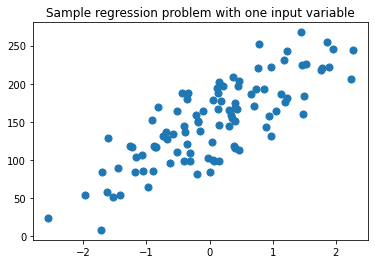

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_regression

np.set_printoptions(precision=2)

uri = "https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt"
fruits = pd.read_table(uri)

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF', '#000000'])
plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples=100, n_features=1,
                             n_informative=1, bias=150.0,
                             noise=30, random_state=0)
plt.scatter(X_R1, y_R1, marker='o', s=50)
plt.show()


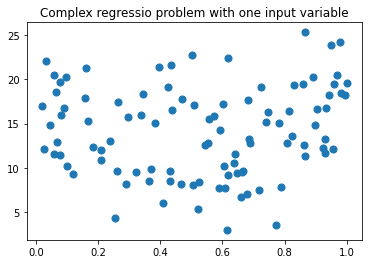

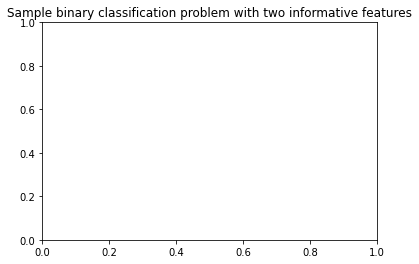

In [50]:
from sklearn.datasets import make_friedman1, make_classification

plt.figure()
plt.title("Complex regressio problem with one input variable")
X_F1, y_F1 = make_friedman1(n_samples=100, n_features=7, random_state=0)
plt.scatter(X_F1[:, 2], y_F1, marker='o', s=50)
plt.show()

plt.figure()
plt.title("Sample binary classification problem with two informative features")
X_C2, y_C2 = make_classification(n_samples=100, n_features=2,
                                 n_redundant=0, n_informative=2,
                                 class_sep=0.5, random_state=0)

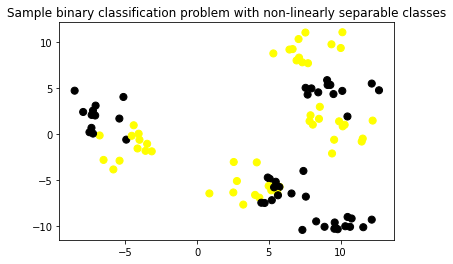

In [51]:
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized


X_D2, y_D2 = make_blobs(n_samples=100, n_features=2,
                        centers=8, cluster_std=1.3,
                        random_state=4)

y_D2 = y_D2 % 2
plt.figure()
plt.title("Sample binary classification problem with non-linearly separable classes")
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
            marker='o', s=50, cmap=cmap_bold)
plt.show()

cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y=True)

(X_crime, y_crime) = load_boston(return_X_y=True)

### The k-NN classifier algorithm

1. Find the most similar instances (X_NN) to X_test that are in X_train;

2. Get the labels y_NN for instances in X_NN;

3. Predict the label for X_test by combining the labels y_NN.
> e.g. simple majority vote.

* With increasing k, single training data points no longer have as dramatic influence the prediction;

> It means lower underfitting when we increase the k value (lower model complexity);

> The decision boundary has much less variance.

* If we increase k to be the total number of points in the training set, the result is a single decision region where all predictions would be the most frequent class.

#### k-NN classification

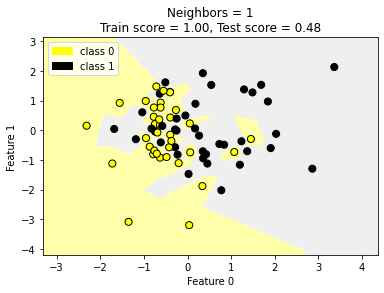

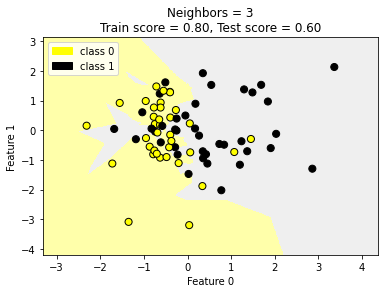

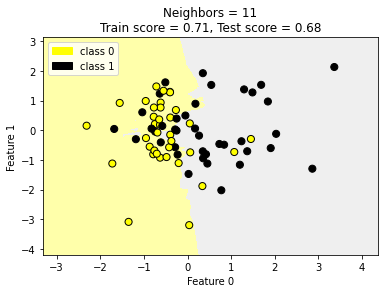

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)

plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, 'uniform', X_test, y_test)

#### k-NN regression

* Similar to the classification, it uses the average of the datas near our value.


In [53]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_R1, y_R1, random_state=0)
knnreg = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print("R-squared test score: {:.3f}".format(
    knnreg.score(X_test, y_test)))

[231.71 148.36 150.59 150.59  72.15 166.51 141.91 235.57 208.26 102.1
 191.32 134.5  228.32 148.36 159.17 113.47 144.04 199.23 143.19 166.51
 231.71 208.26 128.02 123.14 141.91]
R-squared test score: 0.425


#### The r-squared ($R^2$) regression score

* Measures how well a prediction model for regression fits the given data;

* The score is between 0 and 1:
 - A value of 0 corresponds to a constant model that predicts the mean value of all training target values;
 - A value of 1 corresponds to perfect predictions.

* Also known as **coefficient of determination". 

#### Regression model complexity as a function of K

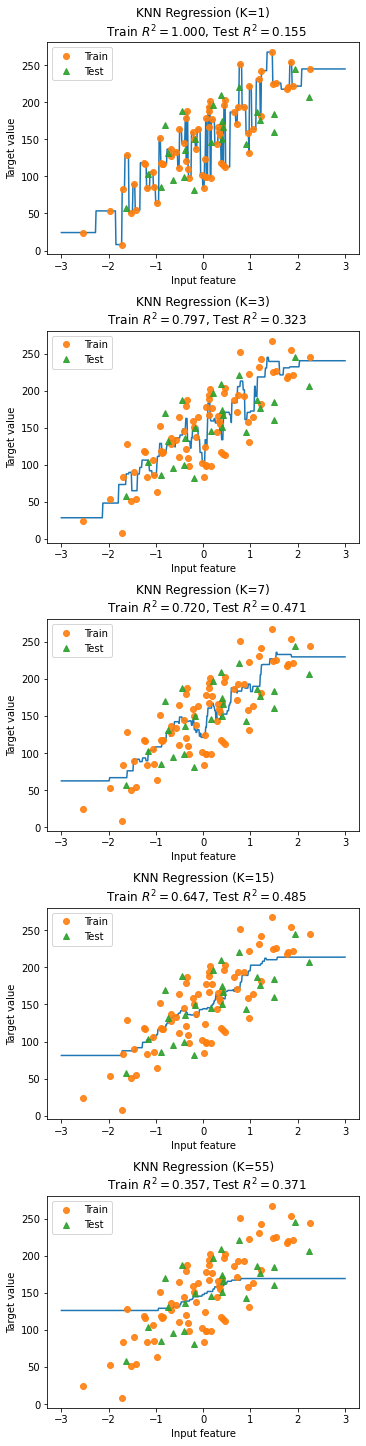

In [54]:
fig, subaxes = plt.subplots(5, 1, figsize=(5,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                    random_state=0)

for thisaxis, K in zip(subaxes, [1,3,7,15,55]):
  knnreg = KNeighborsRegressor(n_neighbors=K).fit(X_train, y_train)
  y_predict_output = knnreg.predict(X_predict_input)
  train_score = knnreg.score(X_train, y_train)
  test_score = knnreg.score(X_test, y_test)
  thisaxis.plot(X_predict_input, y_predict_output)
  thisaxis.plot(X_train, y_train, 'o', alpha=0.9, label="Train")
  thisaxis.plot(X_test, y_test, '^', alpha=0.9, label="Test")
  thisaxis.set_xlabel("Input feature")
  thisaxis.set_ylabel("Target value")
  thisaxis.set_title("KNN Regression (K={})\n\
  Train $R^2 = {:.3f}$, Test $R^2 = {:.3f}$".format(
      K, train_score, test_score))
  thisaxis.legend()
  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

* As before, small values of **k** give models with higher complexity and large values of **k** result in simpler models with lower complexity;

* Until k=55, where the model starts to underfit, it's too simple to do well, even on the training data.

* For k-NN, whe the training data has many instances, or each instance has lots of features, this can slow down the performance of the model (e.g. sparce datasets)

#### k-NN classifier and k-NN regressor important parameters

* Model complexity
 - `n_neighbors`: number of nearest neighbors (k) to consider.
 > default = 5.

* Model fitting
 - `metric`: distance function between data points.
 > default = Minkowski distance with power parameter p=2 (Euclidean).

---

### Linear regression: least-squares

#### Linear models

* Is a *sum of weighted variables* that predicts a target output value given an input data instance;

#### A linear regression model with one variable (feature)

* input instance: $x = (x_0)$
* predicted output: $\hat{y} = \hat{w}_0 x_0 + \hat{b}$
* parameters to estimate: 
 * $\hat{w}_0$ (slope)
 * $\hat{b}$ (y-intercept)

#### Least-squares linear regression (ordinary least-squares)

* Finds $w$ and $b$ that minimizes the mean squared error of the model;
> The sum of squared differences (RSS - residual sum of squares) between predicted target and actual target values.
$RSS(w,b) = \sum^N_{i=1} (y_i - (w \times  x_i + b))^2$

* No parameters to control model complexity.

#### How are linear regression parameters $w$ and $b$ estimated?

* They are estimated from training data;
* There are many different ways to estimate $w$ and $b$:
 * Different methods correspond to diffrent *fit* criteria, goals and ways to control model complexity.

* The learning algorithm finds the parameters that optimize an *objective function*, typically to minimize some kind of *loss function* of the predicted target values vs. actual target values.



In [55]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [45.71]
linear model intercept (b): 148.446
R-squared score (training): 0.679
R-squared score (test): 0.492


> Underscore denotes a quantity derived from training data, as opposed to a user setting.

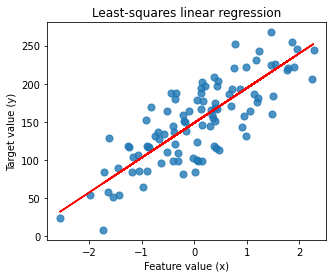

In [56]:
plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

* The k-NN regressor doesn't make a lot of assumptions for k=7 about the structure of the data, and gives potentially accurate but sometimes unstable predictions that are sensitive to small changes in the training data;
> So it has a correspondingly higher training set, r-squared score (0.72) compared to least-squares linear regression (0.679).

* On the other hand, linear models make strong assumptions about the structure of the data, in other words, that the target value can be predicted using a weighted sum of the input variables. It give stable but potentially inaccurate predictions. However in this case, it turns out that the linear model has a strong assumption that there's a linear relationship between the input and output variables happes to be a good fit for this dataset.
> And so it's better at more accurately predicting the y value for new x values that weren't seen during training. And we can see that the linear model gets a slightly better test set score (0.492) versus k-NN (0.471).

---

### Linear regression: Ridge, lasso, and polynomial regression

* Learns $w$, $b$ using the same least-squares criterion but adds a penalty for large variations in $w$ parameters;

$RSS_{ridge}(w,b) = \sum_{i=1}^N (y_i - (w \times x_i + b))^2 + \alpha \sum_{j=1}^p w_{j}^2$

* Once the parameters are learned, the ridge regression prediction formula is the same as ordinary least-squares;

* The addition of a parameter penalty is called **regularization*. It prevents overfitting by restricting the model, typically to reduce its complexity;

* Ridge regression uses **L2 regularization**: minimize sum of squares of $w$ entries;

* The influence of the regularization term is controlled by the $\alpha$ parameter;
> the default value is 1.0, setting alpha to 0 is the case of ordinary least-squares linear regression.

* Higher $\alpha$ means more regularization and simpler models.



In [57]:
# Ridge regression
from sklearn.linear_model import Ridge

(X_crime, y_crime) = load_crime_dataset()
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))


Crime dataset
ridge regression linear model intercept: -3352.423035846137
ridge regression linear model coeff:
[ 1.95e-03  2.19e+01  9.56e+00 -3.59e+01  6.36e+00 -1.97e+01 -2.81e-03
  1.66e+00 -6.61e-03 -6.95e+00  1.72e+01 -5.63e+00  8.84e+00  6.79e-01
 -7.34e+00  6.70e-03  9.79e-04  5.01e-03 -4.90e+00 -1.79e+01  9.18e+00
 -1.24e+00  1.22e+00  1.03e+01 -3.78e+00 -3.73e+00  4.75e+00  8.43e+00
  3.09e+01  1.19e+01 -2.05e+00 -3.82e+01  1.85e+01  1.53e+00 -2.20e+01
  2.46e+00  3.29e-01  4.02e+00 -1.13e+01 -4.70e-03  4.27e+01 -1.23e-03
  1.41e+00  9.35e-01 -3.00e+00  1.12e+00 -1.82e+01 -1.55e+01  2.42e+01
 -1.32e+01 -4.20e-01 -3.60e+01  1.30e+01 -2.81e+01  4.39e+01  3.87e+01
 -6.46e+01 -1.64e+01  2.90e+01  4.15e+00  5.34e+01  1.99e-02 -5.47e-01
  1.24e+01  1.04e+01 -1.57e+00  3.16e+00  8.78e+00 -2.95e+01 -2.33e-04
  3.14e-04 -4.14e-04 -1.79e-04 -5.74e-01 -5.18e-01 -4.21e-01  1.53e-01
  1.33e+00  3.85e+00  3.03e+00 -3.78e+01  1.38e-01  3.08e-01  1.57e+01
  3.31e-01  3.36e+00  1.61e-01 -2.68e

#### The need for feature normalization

* Importante for some ML methods that all features are on the same scale;
> e.g. faster convergence in learning, more uniform of 'fair' influence for all weights;

 > e.g. regularized regression, k-NN, SVM, NN, ..

* Can also depend on the data. More on feature engineering later in the course. For now, we do `MinMax` scaling of the features:
 * For each feature $x_i$: compute the min value $x_i^{MIN}$ and the max value $x_i^{MAX}$ achieved across all instances in the training set;
 * For each feature: transform a given feature $x_i$ value to a scaled version $x_i'$ using the formula:
$x_i' = (x_i - x_i^{MIN})/(x_i^{MAX} - x_i^{MIN})$

In [58]:
# Ridge regression with feature normalization

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: 933.3906385044153
ridge regression linear model coeff:
[  88.69   16.49  -50.3   -82.91  -65.9    -2.28   87.74  150.95   18.88
  -31.06  -43.14 -189.44   -4.53  107.98  -76.53    2.86   34.95   90.14
   52.46  -62.11  115.02    2.67    6.94   -5.67 -101.55  -36.91   -8.71
   29.12  171.26   99.37   75.07  123.64   95.24 -330.61 -442.3  -284.5
 -258.37   17.66 -101.71  110.65  523.14   24.82    4.87  -30.47   -3.52
   50.58   10.85   18.28   44.11   58.34   67.09  -57.94  116.14   53.81
   49.02   -7.62   55.14  -52.09  123.39   77.13   45.5   184.91  -91.36
    1.08  234.09   10.39   94.72  167.92  -25.14   -1.18   14.6    36.77
   53.2   -78.86   -5.9    26.05  115.15   68.74   68.29   16.53  -97.91
  205.2    75.97   61.38  -79.83   67.27   95.67  -11.88]
R-squared score (training): 0.615
R-squared score (test): 0.599
Number of non-zero features: 88


#### Feature normalization: the test set must use identical scaling to the training set

* Fit the scaler using the training set, then apply the same scaler to transform the test set;

* Don't scaler the training and test sets using different scalers: this could lead to random skew in the data;

* Don't fit the scaler using any part of the test data: refering the test data can lead to a form of *data leakage*;
> The training phase has information that is leaked from the test set. The learning method can give unrealistically good estimates on the same test set.

* The resulting model and the transformed features my be harder to interpret.



* Generally, regularization works well when we have relatively small amounts of training data compared to the number of features in the model;

* Regularization becomes less important as the amount of training data you have increases.

In [59]:
# Ridge regression with regularization parameter: alpha
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 88, r-squared training: 0.67, r-squared test: 0.50

Alpha = 1.00
num abs(coeff) > 1.0: 87, r-squared training: 0.66, r-squared test: 0.56

Alpha = 10.00
num abs(coeff) > 1.0: 87, r-squared training: 0.63, r-squared test: 0.59

Alpha = 20.00
num abs(coeff) > 1.0: 88, r-squared training: 0.61, r-squared test: 0.60

Alpha = 50.00
num abs(coeff) > 1.0: 86, r-squared training: 0.58, r-squared test: 0.58

Alpha = 100.00
num abs(coeff) > 1.0: 87, r-squared training: 0.55, r-squared test: 0.55

Alpha = 1000.00
num abs(coeff) > 1.0: 84, r-squared training: 0.31, r-squared test: 0.30



#### Lasso regression is another form of regularized linear regression that uses an **L1 regularization** penalty for training (instead of ridge's L2 penalty)

* L1 penalty: Minimize the sum of the **absolute values** of the coefficients:
$ RSS_{lasso}(w,b) = \sum_{i=1}^N (y_i - (w \times x_i + b))^2 + \alpha \sum_{j=1}^p |w_j|$

* This has the effect of setting parameter weights in $w$ to **zero** for the least influential variables. This is called a **sparse** solution,a kind of feature selection;

* The parameter $\alpha$ controls the amount of L1 regularization (default=1.0);

* The prediction formula is the same as ordinary least-squares;

* When to use ridge vs lasso regression:
 * Ridge: many small/medium sized effects.
 * Lasso: only a few variables with medium/large effect.

In [60]:
# Lasso regression
from sklearn.linear_model import Lasso
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Crime dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_crime), linlasso.coef_)),key = lambda e: -abs(e[1])):
  if e[1] != 0:
    print('\t{}, {:.3f}'.format(e[0], e[1]))

Crime dataset
lasso regression linear model intercept: 1186.612061998579
lasso regression linear model coeff:
[    0.       0.      -0.    -168.18    -0.      -0.       0.     119.69
     0.      -0.       0.    -169.68    -0.       0.      -0.       0.
     0.       0.      -0.      -0.       0.      -0.       0.       0.
   -57.53    -0.      -0.       0.     259.33    -0.       0.       0.
     0.      -0.   -1188.74    -0.      -0.      -0.    -231.42     0.
  1488.37     0.      -0.      -0.      -0.       0.       0.       0.
     0.       0.      -0.       0.      20.14     0.       0.       0.
     0.       0.     339.04     0.       0.     459.54    -0.       0.
   122.69    -0.      91.41     0.      -0.       0.       0.      73.14
     0.      -0.       0.       0.      86.36     0.       0.       0.
  -104.57   264.93     0.      23.45   -49.39     0.       5.2      0.  ]
Non-zero features: 20
R-squared score (training): 0.631
R-squared score (test): 0.624

Features with n

In [61]:
# Lasso regressuib with regularization parameter: alpha
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 0.50
Features kept: 35, r-squared training: 0.65, r-squared test: 0.58

Alpha = 1.00
Features kept: 25, r-squared training: 0.64, r-squared test: 0.60

Alpha = 2.00
Features kept: 20, r-squared training: 0.63, r-squared test: 0.62

Alpha = 3.00
Features kept: 17, r-squared training: 0.62, r-squared test: 0.63

Alpha = 5.00
Features kept: 12, r-squared training: 0.60, r-squared test: 0.61

Alpha = 10.00
Features kept: 6, r-squared training: 0.57, r-squared test: 0.58

Alpha = 20.00
Features kept: 2, r-squared training: 0.51, r-squared test: 0.50

Alpha = 50.00
Features kept: 1, r-squared training: 0.31, r-squared test: 0.30



* The alpha value will be different for different data sets, and depends of the feature preprocessing being used;

#### Polynomial features with linear regression

$x = (x_0, x_1)$

$x' = (x_0, x_1, x_0^2, x_0x_1, x_1^2)$

$\hat{y} = \hat{w_0}x_0 + \hat{w_1}x_1 + \hat{w_{00}}x_0^2 + \hat{w_{01}}x_0x_1 + \hat{w_{11}}x_1^2 + b$

* Generate new features consisting of all polynomial combinations of the original two features ($x_0,x_1$);

* The degree of the polynomial specifies how many variables participate at a time in each new feature (above example: degree 2);

* This is still a weighted linear combination of features, so it's still a linear model, and can use the same least-squares estimation method for $w$ and $b$;

* With polunomial feature transformation we can transform a problem into a higher dimensional regression space, allowing a much richer set of complex functions that we can use to fit to the data;

* Why would we want to transform our data this way?
 * To capture interactions between the original features by adding them as features to the linear model;
 * To make a classification problem easier.

* More generally, we can apply other non-linear transformations to create new features;
> Technically, these are called non-linear basis functions.

* Beware of polynomial feature expansion with high degree, as this can lead to complex models that overfit;
> Thus. polynomial feature expansion os often combined with a regularized learning method like ridge regression.



In [62]:
# Polynomial regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


X_train, X_test, y_train, y_test = train_test_split(X_F1, y_F1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

# 2 regression
print('\nNow we transform the original input data to add\n\
polynomial features up to degree 2 (quadratic)\n')
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_F1)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('(poly deg 2) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

# 3 regression
print('\nAddition of many polynomial features often leads to\n\
overfitting, so we often use polynomial features in combination\n\
with regression that has a regularization penalty, like ridge\n\
regression.\n')

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = Ridge().fit(X_train, y_train)

print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + ridge) linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [ 4.42  6.    0.53 10.24  6.55 -2.02 -0.32]
linear model intercept (b): 1.543
R-squared score (training): 0.722
R-squared score (test): 0.722

Now we transform the original input data to add
polynomial features up to degree 2 (quadratic)

(poly deg 2) linear model coeff (w):
[ 3.41e-12  1.66e+01  2.67e+01 -2.21e+01  1.24e+01  6.93e+00  1.05e+00
  3.71e+00 -1.34e+01 -5.73e+00  1.62e+00  3.66e+00  5.05e+00 -1.46e+00
  1.95e+00 -1.51e+01  4.87e+00 -2.97e+00 -7.78e+00  5.15e+00 -4.65e+00
  1.84e+01 -2.22e+00  2.17e+00 -1.28e+00  1.88e+00  1.53e-01  5.62e-01
 -8.92e-01 -2.18e+00  1.38e+00 -4.90e+00 -2.24e+00  1.38e+00 -5.52e-01
 -1.09e+00]
(poly deg 2) linear model intercept (b): -3.206
(poly deg 2) R-squared score (training): 0.969
(poly deg 2) R-squared score (test): 0.805


Addition of many polynomial features often leads to
overfitting, so we often use polynomial features in combination
with regression that has a regularization penalty, like ridge
regression.

(p

## Datasets

In [0]:
# from sklearn.datasets import make_classification, make_blobs
# from matplotlib.colors import ListedColormap
# from sklearn.datasets import load_breast_cancer

# cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])


# # synthetic dataset for simple regression
# from sklearn.datasets import make_regression
# plt.figure()
# plt.title('Sample regression problem with one input variable')
# X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
#                             n_informative=1, bias = 150.0,
#                             noise = 30, random_state=0)
# plt.scatter(X_R1, y_R1, marker= 'o', s=50)
# plt.show()


# # synthetic dataset for more complex regression
# from sklearn.datasets import make_friedman1
# plt.figure()
# plt.title('Complex regression problem with one input variable')
# X_F1, y_F1 = make_friedman1(n_samples = 100,
#                            n_features = 7, random_state=0)

# plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
# plt.show()

# # synthetic dataset for classification (binary) 
# plt.figure()
# plt.title('Sample binary classification problem with two informative features')
# X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
#                                 n_redundant=0, n_informative=2,
#                                 n_clusters_per_class=1, flip_y = 0.1,
#                                 class_sep = 0.5, random_state=0)
# plt.scatter(X_C2[:, 0], X_C2[:, 1], c=y_C2,
#            marker= 'o', s=50, cmap=cmap_bold)
# plt.show()


# # more difficult synthetic dataset for classification (binary) 
# # with classes that are not linearly separable
# X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8,
#                        cluster_std = 1.3, random_state = 4)
# y_D2 = y_D2
# # from adspy_shared_utilities import load_crime_dataset % 2
# plt.figure()
# plt.title('Sample binary classification problem with non-linearly separable classes')
# plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
#            marker= 'o', s=50, cmap=cmap_bold)
# plt.show()


# # Breast cancer dataset for classification
# cancer = load_breast_cancer()
# (X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


# # Communities and Crime dataset
# (X_crime, y_crime) = load_crime_dataset()

---
### Logistic regression

$\hat{y} = \frac{1}{1 + exp[-(\hat{b}+ \hat{w}_1 \times \hat{x}_1 + ... \hat{w}_n \times \hat{x}_n)]}$

* Still computes a weighted sum of the input features $x_i$ and the intercept term $b$, but it runs this result through a special non-linear function $f$ (logistic function);
> It's an S shaped function that gets closer to 1 as the input value increases above 0 and closer to 0 as the input decreases far below 0.

* The output from logistic regression formula, can be interpreted as the probability that the input data instance belongs to the positive class, given its input features;

* Logistic regression gives a linear decision boundary between the classes;







A fruit with height 6 and width 8 is predicted to be: an apple
A fruit with height 10 and width 7 is predicted to be: not an apple
Accuracy of Logistic regression classifier on training set: 0.80
Accuracy of Logistic regression classifier on test set: 0.73


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


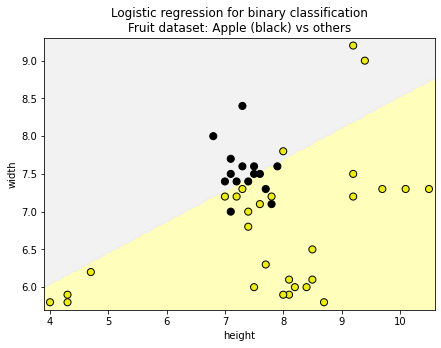

In [64]:
from sklearn.linear_model import LogisticRegression

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
y_fruits_apple = y_fruits_2d == 1   # make into a binary problem: apples vs everything else 
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.to_numpy(),
                y_fruits_apple.to_numpy(),
                random_state = 0))

clf = LogisticRegression(C=100).fit(X_train, y_train)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None,
                                         None, 'Logistic regression \
for binary classification\nFruit dataset: Apple (black) vs others',
                                         subaxes)

h = 6
w = 8
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][clf.predict([[h,w]])[0]]))

h = 10
w = 7
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][clf.predict([[h,w]])[0]]))
subaxes.set_xlabel('height')
subaxes.set_ylabel('width')

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Logistic regression: regularization

* L2 regularization is "on" by default (like ridge regression);
* Parameter `C` controls amount of regularization (default is 1.0);
> For SVM and logistic regression high values of C means **less** regularization. With high values of C, the model tries to fit the training data as well as possible. While with small values it tries to find model coefficients close to 0, even if that model fits the training data a little bit worse.
* As with regularized linear regression, it can be important to normalize all features so that they are on the same scale.

#### Logistic regression on simple synthetic dataset

#### Application to real dataset

In [65]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = LogisticRegression().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of Logistic regression classifier on training set: 0.96
Accuracy of Logistic regression classifier on test set: 0.96


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


---
### Linear classifiers: Support Vector Machines

#### Linear Support Vector Machine

$f(x,w,b) = sign(w \circ x + b) = sign(\sum w[i]x[i]+b$

#### Classifier margin

* Defined as the maximum width the decison boundary area can be increased before hitting a data point.

#### Maximum margin linear classifier

* The linear classifier with maximum margin is a linear suport vector machine (LSVM or SVM with linear kernel);

* The best classifier has the maximum amount of margin;


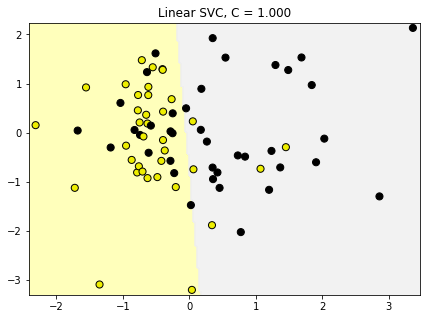

In [66]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
this_C = 1.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None, None, title, subaxes)

#### Linear Support Vector Machine: C parameter

* The strength of regularization is determined by `C`.
 * Large values of `C` means less regularization;
 > Fit the training data as well as possible. Each individual data point is important to classify correctly, even with a small margen decision boundary.

 * Smaller values of `C` means more regularization.
 > More tolerant for errors on individual data points. Encourages the classifier to find the large marge on decision boundary (even with misclassification).

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


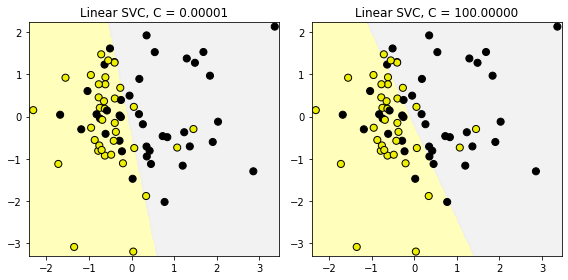

In [67]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state = 0)
fig, subaxes = plt.subplots(1, 2, figsize=(8, 4))

for this_C, subplot in zip([0.00001, 100], subaxes):
    clf = LinearSVC(C=this_C).fit(X_train, y_train)
    title = 'Linear SVC, C = {:.5f}'.format(this_C)
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             None, None, title, subplot)
plt.tight_layout()

#### Application to real dataset

In [68]:
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = LinearSVC().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of Linear SVC classifier on training set: 0.94
Accuracy of Linear SVC classifier on test set: 0.92


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Linear models: pros and cons

* **Pros**:
 * Simple and easy to train;
 * Fast prediction;
 * Scales well to very large datasets;
 * Works well with sparse data;
 * Reasons for prediction are relatively easy to interpret.

* **Cons**:
 * For lower-dimensional data, other models may have superior generalization performance;
 * For classification, data may not be linearly separable.

### Multi-class classification with linear models

#### LinearSVC with M classes generates M one vs rest classifiers.

* It converts a multiclass classification problem into a series of binary problems.



In [69]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

clf = LinearSVC(C=5, random_state = 67).fit(X_train, y_train)
print('Coefficients:\n', clf.coef_)
print('Intercepts:\n', clf.intercept_)

Coefficients:
 [[-0.26  0.71]
 [-1.63  1.16]
 [ 0.03  0.29]
 [ 1.24 -1.64]]
Intercepts:
 [-3.29  1.2  -2.72  1.16]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Multi-class results on the fruit dataset

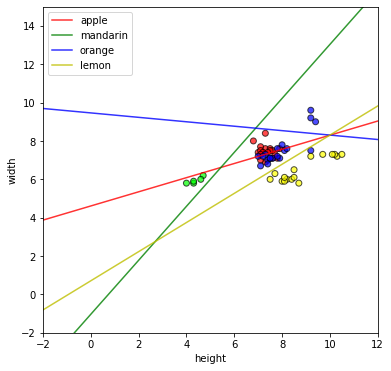

In [70]:
plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_fruits = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X_fruits_2d[['height']], X_fruits_2d[['width']],
           c=y_fruits_2d, cmap=cmap_fruits, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(-10, 15)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    # Since class prediction with a linear model uses the formula y = w_0 x_0 + w_1 x_1 + b, 
    # and the decision boundary is defined as being all points with y = 0, to plot x_1 as a 
    # function of x_0 we just solve w_0 x_0 + w_1 x_1 + b = 0 for x_1:
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.8)
    
plt.legend(target_names_fruits)
plt.xlabel('height')
plt.ylabel('width')
plt.xlim(-2, 12)
plt.ylim(-2, 15)
plt.show()

### Kernelized Support Vector Machines (SVMs)

* Provide more complex models that can go beyond linear decision boundaries;

* Used for classification and regression;

* It take the original input data space and transforme it to a new higher dimensional feature space, where it becomes much easier to classify the transformed data using a linear classifier;
 * For example transform the data by adding a second dimension/feature (set to the squared value of the first feature). The data transformation makes it possible to solve this with a linear classifier.

  $v_i = (x_i,x_i^2)$

> A similar technique is add polynomial features to a linear regression problem.

* Another example is mapping a 2D classification problem to a 3D feature space to make it linearly separable; 

* The different kernels available for the kernelized SVM correspond to different transformations;

* The radial basis function (RBF) and de polynomial kernels are the most used;

* The kernel function is a similarity measure (modified dot product) between data points;
> For RBF the similarity between two points and the transformed features space is an exponentially decaying function of the distance between the vectors and the original input space:
$K(x,x') = exp[-\gamma \times ||x - x'||^2]$

* **The kernel trick** means that internally the algorithm doesn't have to perform this actual transformation on the data points to the new high dimensional feature space. Instead, the kernel compute just in terms of similarity calculations between pairs of points in the high dimensional space where the transformed feature representation is implicit;

* The SVM still using a maximum margin principle to find these decision boundaries, but because of the non-linear transformation of the data these boundaries may no longer be equally distant from the margin edge points in the original input space;



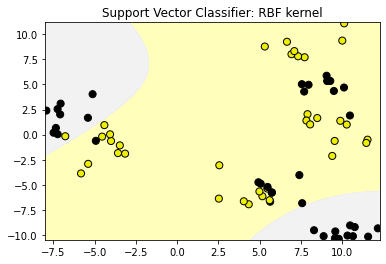

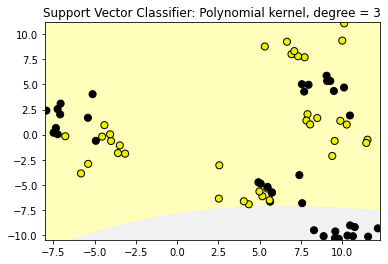

In [71]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)

# The default SVC kernel is radial basis function (RBF)
plot_class_regions_for_classifier(SVC().fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'Support Vector Classifier: RBF kernel')

# Compare decision boundries with polynomial kernel, degree = 3
plot_class_regions_for_classifier(SVC(kernel = 'poly', degree = 3)
                                 .fit(X_train, y_train), X_train,
                                 y_train, None, None,
                                 'Support Vector Classifier: Polynomial kernel, degree = 3')

#### Support Vector Machine with RBF kernel: gamma parameter

* Gamma ($\gamma$) is the kernel width parameter. It controls how far the influence of a single trending example reaches;
> Which affects how tightly the decision boundaries end up surrounding points in the input space.

* **Small** gamma means a larget similarity radius. Which results in more points being group together and smoother decision boundaries;

* **Larger** gamma the kernel value decay is more quickly and points have to be very close to be considered similar. This results in more complex, tighly constrained decision boundaries;



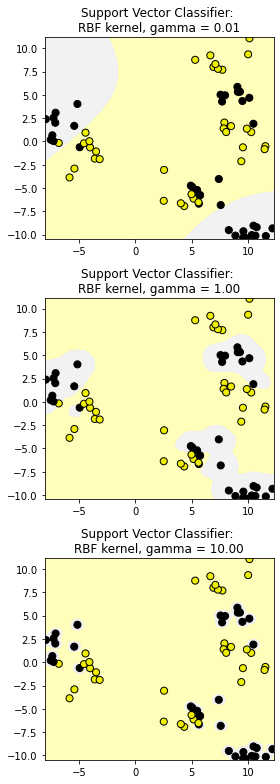

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(3, 1, figsize=(4, 11))

for this_gamma, subplot in zip([0.01, 1.0, 10.0], subaxes):
    clf = SVC(kernel = 'rbf', gamma=this_gamma).fit(X_train, y_train)
    title = 'Support Vector Classifier: \nRBF kernel, gamma = {:.2f}'.format(this_gamma)
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             None, None, title, subplot)
    plt.tight_layout()

#### Support Vector Machine with RBF kernel: using both C and gamma parameter

* `C` controls the tradeoff between satisfying the maximum margin criterion to find the simple decision boundary and avoiding misclassification errors on the training set;

* It interacts with the gamma parameter.

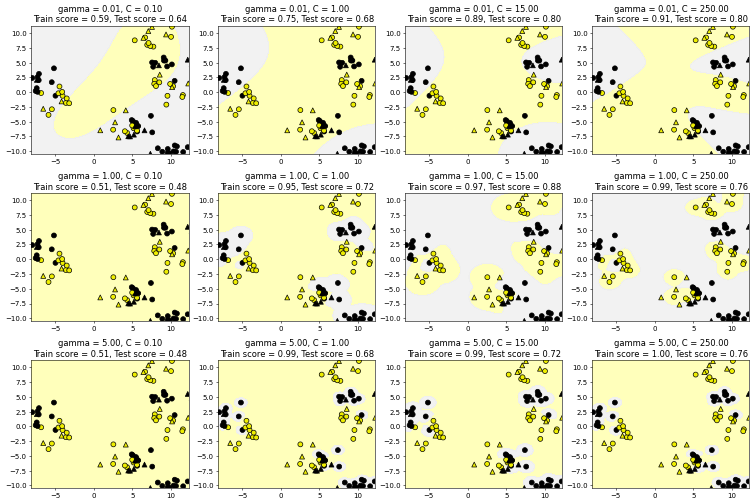

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):
    
    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(this_gamma, this_C)
        clf = SVC(kernel = 'rbf', gamma = this_gamma,
                 C = this_C).fit(X_train, y_train)
        plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                                 X_test, y_test, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Application of SVMs to a real dataset: unnormalized data

* Is important to normalize the input data so that all the features have comparable units that are on the same scale; 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer,
                                                   random_state = 0)

clf = SVC(C=10).fit(X_train, y_train)
print('Breast cancer dataset (unnormalized features)')
print('Accuracy of RBF-kernel SVC on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RBF-kernel SVC on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset (unnormalized features)
Accuracy of RBF-kernel SVC on training set: 0.92
Accuracy of RBF-kernel SVC on test set: 0.94


### Application of SVMs to a real dataset: normalized data with feature preprocessing using minmax scaling

In [75]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(C=10).fit(X_train_scaled, y_train)
print('Breast cancer dataset (normalized with MinMax scaling)')
print('RBF-kernel SVC (with MinMax scaling) training set accuracy: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('RBF-kernel SVC (with MinMax scaling) test set accuracy: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset (normalized with MinMax scaling)
RBF-kernel SVC (with MinMax scaling) training set accuracy: 0.99
RBF-kernel SVC (with MinMax scaling) test set accuracy: 0.97


#### Pros and cons

* **Pros**:
 * Can perform well on a range of datasets;
 * Versatile: different kernel functions can be specified or custom kernels can be defined for specific data types;
 * Works well for both low and high-dimensional data.

* **Cons**:
 * Efficiency (runtime speed and memory usage) decreases as training set size increases (e.g. over 50000 samples);
 * Needs careful normalization of input data and parameter tuning;
 * Does not provide direct probability estimates (but can be estimated using Platt scaling for example);
 > Platt scaling transforms the output of the classifier to a probability distribution of classes by fitting a logistic regression model to the classifiers scores.
 * Difficult to interpret why a prediction was made.

#### Important parameters (model complexity)

* Kernel: type of kernel function to be used.
 * Default is `rbf` for radial basis function, other types include `poly`(polynomial);
* Kernel parameters - gamma ($\gamma$) is the RBF kernel width;
* `C` is the regularization parameter;
> Typically `C` and `gamma` are tuned at the same time.

---
### Cross-validation

* The reason we divided the original data into training and test sets was to use the test set as a way to estimate how well the model trained on the training data would generalize to new previously unseen data;
> The test set should be drawn from the same underlying distribution as the training set.

* Cross-validation goes beyond evaluating a single model using a single train/test split of the data by using multiple train/test splits, each of which is used to train and evaluate a separate model;

* As the accuracy score you get from running a classifier can vary quite a bit just by chance depending on the specific samples that happen to end up in the training set. 
> Cross-validation basically gives more stable and reliable estimates of how the classifiers likely to perform on average by running multiple different training test slipts and then averaging the results, instead of relying entirely on a single particular training set.

#### K-fold cross-validation (K = 5 or 10)

1. The original dataset is partitioned into five parts (folds) of equal or close to equal size;
2. Then a series of five models is trained one per fold;
> For example, the first model is trained using folds 2 through 5 as the training set and evaluated using fold 1 as the test set, and so on. 
3. When the process is done, we have five accuracy values (k=5), one per fold.

#### Example based on k-NN classifier with fruit dataset (2 features)

In [76]:
from sklearn.model_selection import cross_val_score
# by default cross_val_score does 5-fold
clf = KNeighborsClassifier(n_neighbors = 5)
X = X_fruits_2d.to_numpy()
y = y_fruits_2d.to_numpy()
cv_scores = cross_val_score(clf, X, y, cv=3)

print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation scores (3-fold): [0.8  0.75 0.84]
Mean cross-validation score (3-fold): 0.797


#### A note on performing cross-validation for more advanced scenarios.

In some cases (e.g. when feature values have very different ranges), we've seen the need to scale or normalize the training and test sets before use with a classifier. The proper way to do cross-validation when you need to scale the data is *not* to scale the entire dataset with a single transform, since this will indirectly leak information into the training data about the whole dataset, including the test data (see the lecture on data leakage later in the course).  Instead, scaling/normalizing must be computed and applied for each cross-validation fold separately.  To do this, the easiest way in scikit-learn is to use *pipelines*.  While these are beyond the scope of this course, further information is available in the scikit-learn documentation here:

http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

or the Pipeline section in the recommended textbook: Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido (O'Reilly Media).

#### Stratified cross-validation

* Stratified folds each contain a proportion of classes that maches the overall dataset. Now, all classes will be fairly represented in the test set;

* For regression, scikit-learn uses regular k-fold cross-validation since the concept of preserving class proportions isn't something that's really relevant for everyday regression problems.

#### Leave-one-out cross-validation (with N samples in dataset)

* Is just k-fold cross-validation with K sets to the number of data samples in the dataset;
> Each fold consists of a single sample as the test set and the rest of the data as the training set.

* Better for small datasets.

#### Validation curve example

* Show sensitivity to changes in an important parameter;

* It does 3-fold cross validation by default, but it can be ajusted. You can also specify a classifier, parameter name, and a set of parameter values you want to sweep across;

* It returns two-dimensional arrays corresponding to evaluation on the training set and the test set. Each array has one row per parameter value in the sweep and the number of columns is the number of cross-validation folds that are used.

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

In [78]:
print(train_scores)

[[0.46 0.44 0.42]
 [0.85 0.72 0.75]
 [0.92 0.9  0.93]
 [1.   1.   0.97]]


In [79]:
print(test_scores)

[[0.5  0.3  0.32]
 [0.85 0.7  0.63]
 [0.55 0.85 0.68]
 [0.4  0.2  0.37]]


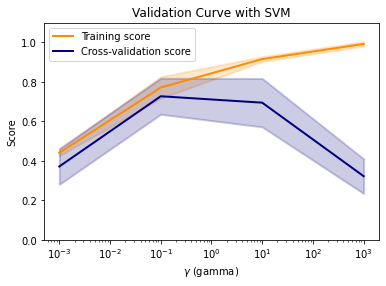

In [80]:
# This code based on scikit-learn validation_plot example
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

* The validation curve shows the mean cross-validation accuracy (solid lines) for training (orange) and test (blue) sets as a function of the SVM parameter (gamma);

* It also shows the variation around the mean (shaded region) as computed from k-fold cross-validation scores.

---
### Decision Trees

* Can be used for classification and regression;

* It learns a series of explicit if/then rules on feature values that result in a decision that predicts the target value;

* The goal when building a decision tree is to find the sequence of questions (split rules or split points) that has the best accuracy at classifying the data in the fewest steps;
> An informative split of the data is one that does an excellent job at separating one class from the others.

* The algorithm starts by finding the feature that leads to the most informative split (some examples can still be incorrectly classified or need further splitting)

* Trees whose leaf nodes each have all the same target value are called **pure**, as opposed to **mixed** where the leaf nores are allowed to contain at least some mixture of the classes;

* To predict the class of a new instance given its feature measurements, using the decision tree we simply start at the root of the decision tree and take the decision at each level based on the appropriate feature measurement until we get to a leafnode;
> The prediction is then just the majority class of the instances in that leafnode.

* For regression the leafnode prediction would be the mean value of the target values for the training points in that leaf;


In [81]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 3)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.97


#### Controlling the model complexity of decision trees

* One strategy to prevent overfitting is to prevent the tree from becoming really detailed and complex by stopping its growth early, this is called **pre-pruning**;
> We can control it by limiting either the maximum depth of the tree using the `max_depth` parameter or the `max_leafnodes` (maximum number of leafnores) parameter. We can also set a threshold on the minimum number of instances that must be in a node to consider splitting it via `min_samples_leaf` paramaeter.

* Another strategy is to build a complete tree with pure leaves but then to prune back the tree into a simpler form, this is called **post-pruning** or just **pruning**;

#### Setting max decision tree depth to help avoid overfitting

In [82]:
clf2 = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.98
Accuracy of Decision Tree classifier on test set: 0.97


#### Visualizing decision trees

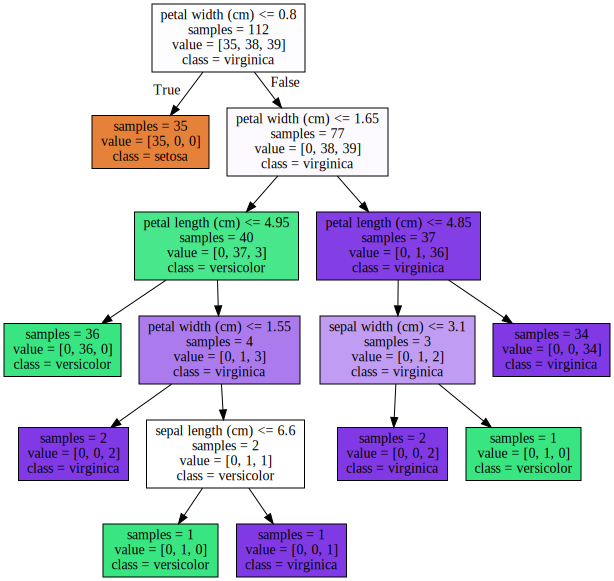

In [83]:
plot_decision_tree(clf, iris.feature_names, iris.target_names)

#### Pre-pruned version (max_depth = 3)

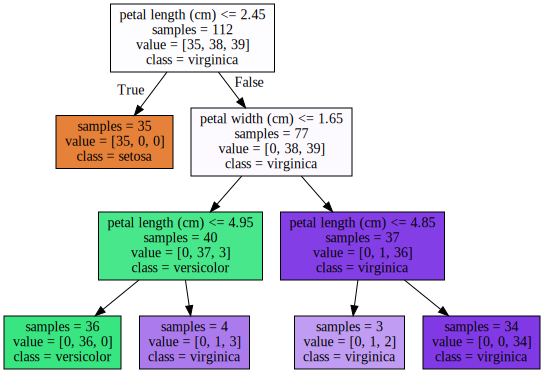

In [84]:
plot_decision_tree(clf2, iris.feature_names, iris.target_names)

#### Feature importance: how important is a feature to overall prediction accuracy?

* A number between 0 and 1 assigned to each feature;
* Feature importance of 0 means the features was not used in prediction. While feature importance of 1 means the feature predicts the target perfectly;
* All feature importance are normalized to sum to 1.

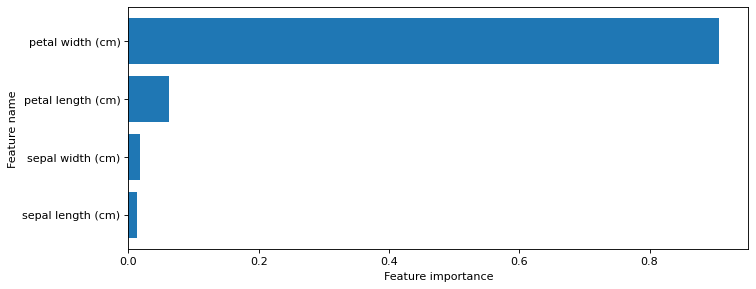

Feature importances: [0.01 0.02 0.06 0.91]


In [85]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, iris.feature_names)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

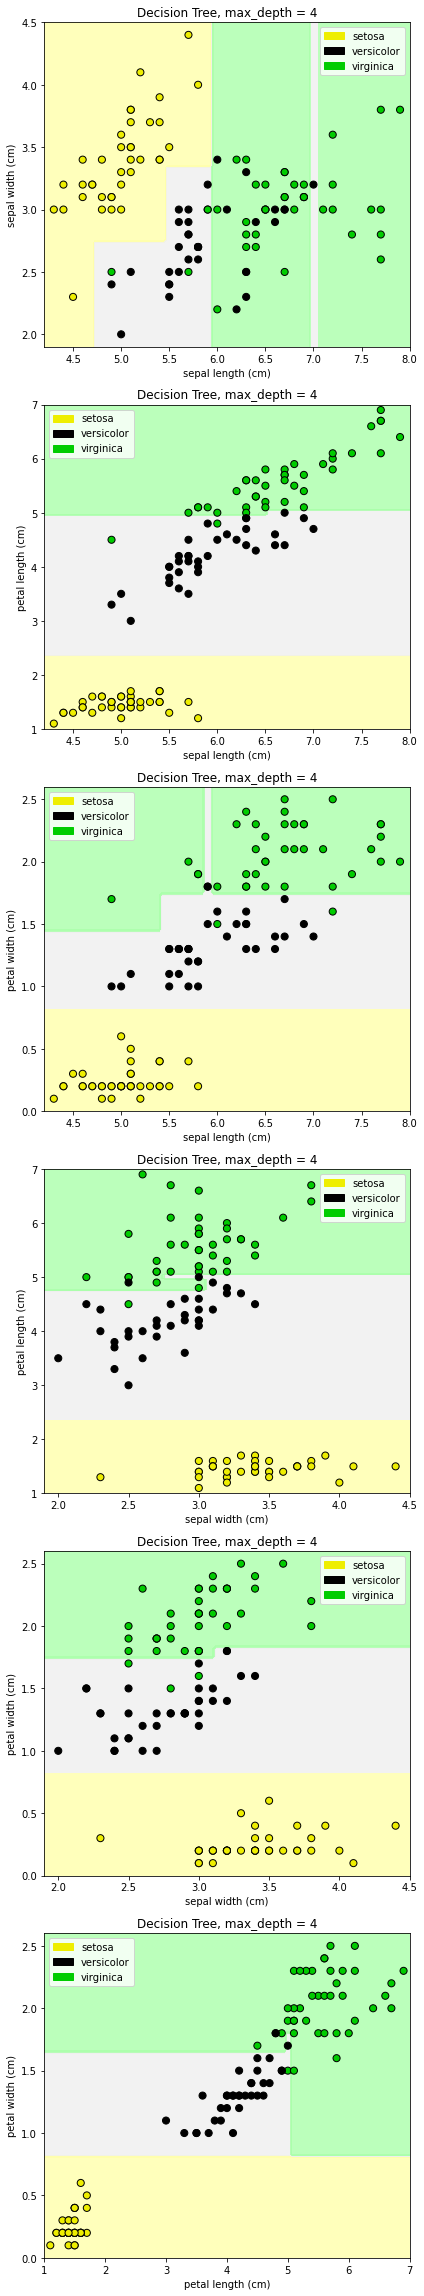

In [86]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
tree_max_depth = 4

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
    
    axis.set_xlabel(iris.feature_names[pair[0]])
    axis.set_ylabel(iris.feature_names[pair[1]])
    
plt.tight_layout()
plt.show()

#### Decision Trees on a real-world dataset

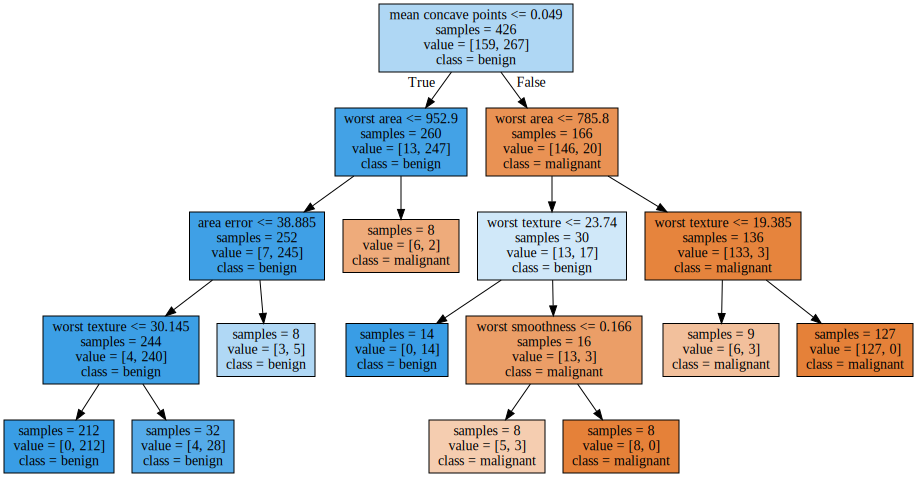

In [87]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 8,
                            random_state = 0).fit(X_train, y_train)

plot_decision_tree(clf, cancer.feature_names, cancer.target_names)

Breast cancer dataset: decision tree
Accuracy of DT classifier on training set: 0.96
Accuracy of DT classifier on test set: 0.94


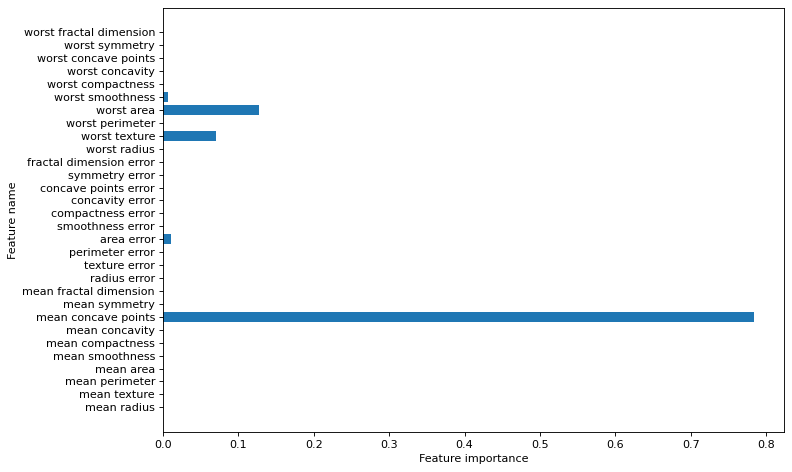

In [88]:
print('Breast cancer dataset: decision tree')
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(clf, cancer.feature_names)
plt.tight_layout()

plt.show()

#### Decision trees: pros and cons

* **Pros**:
 * Easily visualized and interpreted;
 * No feature normalization or scaling typically needed;
 * Work well with datasets using a mixture of feature types (continuous, categorical, binary).

* **Cons**:
 * Even after tuning, decision trees can often still overfit;
 * Usually need an ensemble of trees for better generalization performance.

#### DecisionTreeClassifier key parameters

* `max_depth` controls maximum depth (number of split points). Most common way to reduce tree complexity and overfitting;

* `min_samples_leaf` is the threshold for the minimum of data instances a leaf can have to avoid further splitting;

* `max_leaf_nodes` limits total number of leaves in the tree;

* In practice, adjusting only one of these is enough to reduce overfitting.

---

## A few useful things to know about machine learning

This article by Prof. Pedro Domingos provides a bit more background and discussion of the essential concepts in machine learning covered in Modules 1 and 2. It covers topics such as overfitting, the role of data vs model vs features, and the use of ensembles, where many models are learned instead of just one (something we look at with random forests).

Domingos, P. (2012). [A few useful things to know about machine learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf). Communications of the ACM, 55(10), 78. doi:10.1145/2347736.2347755

---

## Ed Yong: Genetic Test for Autism Refuted 

[This article by Ed Yong](https://www.the-scientist.com/news-opinion/genetic-test-for-autism-refuted-38511) in The Scientist is included because it describes a real-world example of a prediction problem in the health/medical sciences domain - training a classifier to predict risk of autism spectrum disorder (ASD) based on genetic markers - as well as including discussion of potential overfitting of the classifier (by training and testing on the same data) as one possible issue, among other factors, by researchers attempting to replicate the study.

---

## Assignment 2


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


np.random.seed(0)
n = 15
x = np.linspace(0,10,n) + np.random.randn(n)/5
y = np.sin(x)+x/6 + np.random.randn(n)/10


X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

# You can use this function to help you visualize the dataset by
# plotting a scatterplot of the data points
# in the training and test sets.
def part1_scatter():
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.figure()
    plt.scatter(X_train, y_train, label='training data')
    plt.scatter(X_test, y_test, label='test data')
    plt.legend(loc=4);
    
    
# NOTE: Uncomment the function below to visualize the data, but be sure 
# to **re-comment it before submitting this assignment to the autograder**.   
#part1_scatter()


### Question 1

Write a function that fits a polynomial LinearRegression model on the *training data* `X_train` for degrees 1, 3, 6, and 9. (Use PolynomialFeatures in sklearn.preprocessing to create the polynomial features and then fit a linear regression model) For each model, find 100 predicted values over the interval x = 0 to 10 (e.g. `np.linspace(0,10,100)`) and store this in a numpy array. The first row of this array should correspond to the output from the model trained on degree 1, the second row degree 3, the third row degree 6, and the fourth row degree 9.


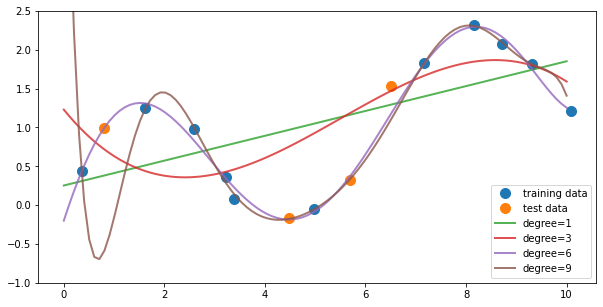

In [95]:
def answer_one():
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    
    pred = np.zeros([4,100])
    X_predict = np.linspace(0,10,100).reshape(-1,1)
    count = 0
    degrees = [1,3,6,9]
    
    for value in degrees:
        poly = PolynomialFeatures(degree=value)
        X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
        X_predict_poly = poly.fit_transform(X_predict)
        linreg = LinearRegression().fit(X_train_poly, y_train)
        tmp_pred = linreg.predict(X_predict_poly).reshape(1,-1)
        pred[count,:] = tmp_pred
        count += 1  
    return pred

def plot_one(degree_predictions):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(10,5))
    plt.plot(X_train, y_train, 'o', label='training data', markersize=10)
    plt.plot(X_test, y_test, 'o', label='test data', markersize=10)
    for i,degree in enumerate([1,3,6,9]):
        plt.plot(np.linspace(0,10,100), degree_predictions[i], alpha=0.8, lw=2, label='degree={}'.format(degree))
    plt.ylim(-1,2.5)
    plt.legend(loc=4)

plot_one(answer_one())

### Question 2

Write a function that fits a polynomial LinearRegression model on the training data `X_train` for degrees 0 through 9. For each model compute the $R^2$ (coefficient of determination) regression score on the training data as well as the the test data, and return both of these arrays in a tuple.

*This function should return one tuple of numpy arrays `(r2_train, r2_test)`. Both arrays should have shape `(10,)`*

In [97]:
def answer_two():
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics.regression import r2_score

    train_out = np.zeros([10,1])
    test_out = np.zeros([10, 1])
    degrees = range(0,10)
    
    for value in degrees:
        poly = PolynomialFeatures(degree=value)
        X_train_poly = poly.fit_transform(X_train.reshape(-1,1))
        X_test_poly = poly.fit_transform(X_test.reshape(-1,1))
        linreg = LinearRegression().fit(X_train_poly, y_train)
        r2_train = r2_score(y_train, linreg.predict(X_train_poly))
        r2_test = r2_score(y_test, linreg.predict(X_test_poly))
        train_out[value] = r2_train
        test_out[value] = r2_test
        train_out = train_out.flatten()
        test_out = test_out.flatten()

    return (train_out, test_out)
answer_two()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


(array([0.  , 0.43, 0.45, 0.59, 0.92, 0.98, 0.99, 0.99, 1.  , 1.  ]),
 array([-0.48, -0.45, -0.07,  0.01,  0.73,  0.88,  0.92,  0.92,  0.63,
        -0.65]))

### Question 3

Based on the $R^2$ scores from question 2 (degree levels 0 through 9), what degree level corresponds to a model that is underfitting? What degree level corresponds to a model that is overfitting? What choice of degree level would provide a model with good generalization performance on this dataset? 

Hint: Try plotting the $R^2$ scores from question 2 to visualize the relationship between degree level and $R^2$. Remember to comment out the import matplotlib line before submission.

*This function should return one tuple with the degree values in this order: `(Underfitting, Overfitting, Good_Generalization)`. There might be multiple correct solutions, however, you only need to return one possible solution, for example, (1,2,3).* 

(0, 9, 6)

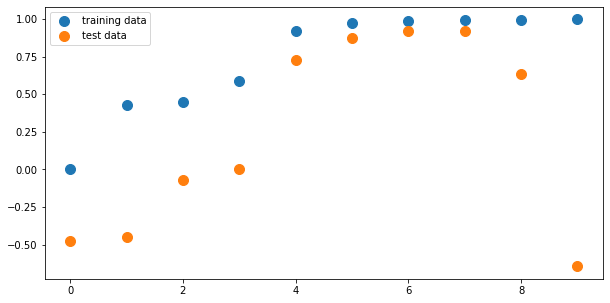

In [101]:
def answer_three():
  import matplotlib.pyplot as plt
  %matplotlib inline
  
  (results_train, results_test) = answer_two()

  plt.figure(figsize=(10,5))
  plt.plot(range(0,10,1), results_train, 'o', label='training data', markersize=10)
  plt.plot(range(0,10,1), results_test, 'o', label='test data', markersize=10)
  plt.legend()
  
  return (0,9,6)
answer_three()


### Question 4

Training models on high degree polynomial features can result in overly complex models that overfit, so we often use regularized versions of the model to constrain model complexity, as we saw with Ridge and Lasso linear regression.

For this question, train two models: a non-regularized LinearRegression model (default parameters) and a regularized Lasso Regression model (with parameters `alpha=0.01`, `max_iter=10000`) both on polynomial features of degree 12. Return the $R^2$ score for both the LinearRegression and Lasso model's test sets.

*This function should return one tuple `(LinearRegression_R2_test_score, Lasso_R2_test_score)`*

In [103]:
def answer_four():
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import Lasso, LinearRegression
    from sklearn.metrics.regression import r2_score

    poly = PolynomialFeatures(degree=12)
    X_train_poly = poly.fit_transform(X_train.reshape(-1,1))
    X_test_poly = poly.fit_transform(X_test.reshape(-1,1))
    
    linreg = LinearRegression().fit(X_train_poly, y_train)
    score_linreg = linreg.score(X_test_poly, y_test)
    
    linlasso = Lasso(alpha=0.01, max_iter=10000).fit(X_train_poly, y_train)
    score_linlasso = linlasso.score(X_test_poly, y_test)
    

    return (score_linreg, score_linlasso)
answer_four()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3556421695890253, tolerance: 0.0006894982540382801
  positive)


(-4.312001797497546, 0.8406625614750235)

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

uri = "https://raw.githubusercontent.com/tianhuaiyuan/Applied-machine-learning-in-python/master/mushrooms.csv"
mush_df = pd.read_csv(uri)
mush_df2 = pd.get_dummies(mush_df)

X_mush = mush_df2.iloc[:,2:]
y_mush = mush_df2.iloc[:,1]

# use the variables X_train2, y_train2 for Question 5
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_mush, y_mush, random_state=0)

# For performance reasons in Questions 6 and 7, we will create a smaller version of the
# entire mushroom dataset for use in those questions.  For simplicity we'll just re-use
# the 25% test split created above as the representative subset.
#
# Use the variables X_subset, y_subset for Questions 6 and 7.
X_subset = X_test2
y_subset = y_test2

### Question 5

Using `X_train2` and `y_train2` from the preceeding cell, train a DecisionTreeClassifier with default parameters and random_state=0. What are the 5 most important features found by the decision tree?

As a reminder, the feature names are available in the `X_train2.columns` property, and the order of the features in `X_train2.columns` matches the order of the feature importance values in the classifier's `feature_importances_` property. 

*This function should return a list of length 5 containing the feature names in descending order of importance.*

*Note: remember that you also need to set random_state in the DecisionTreeClassifier.*

In [106]:
def answer_five():
    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(random_state=0).fit(X_train2, y_train2)
    Series = pd.Series(data=clf.feature_importances_, index=X_train2.columns.values)
    
    best_features = Series.sort_values(axis=0, ascending=False).index.tolist()

    return best_features[:5]

answer_five()

['odor_n', 'stalk-root_c', 'stalk-root_r', 'spore-print-color_r', 'odor_l']

### Question 6

For this question, we're going to use the `validation_curve` function in `sklearn.model_selection` to determine training and test scores for a Support Vector Classifier (`SVC`) with varying parameter values.  Recall that the validation_curve function, in addition to taking an initialized unfitted classifier object, takes a dataset as input and does its own internal train-test splits to compute results.

**Because creating a validation curve requires fitting multiple models, for performance reasons this question will use just a subset of the original mushroom dataset: please use the variables X_subset and y_subset as input to the validation curve function (instead of X_mush and y_mush) to reduce computation time.**

The initialized unfitted classifier object we'll be using is a Support Vector Classifier with radial basis kernel.  So your first step is to create an `SVC` object with default parameters (i.e. `kernel='rbf', C=1`) and `random_state=0`. Recall that the kernel width of the RBF kernel is controlled using the `gamma` parameter.  

With this classifier, and the dataset in X_subset, y_subset, explore the effect of `gamma` on classifier accuracy by using the `validation_curve` function to find the training and test scores for 6 values of `gamma` from `0.0001` to `10` (i.e. `np.logspace(-4,1,6)`). Recall that you can specify what scoring metric you want validation_curve to use by setting the "scoring" parameter.  In this case, we want to use "accuracy" as the scoring metric.

For each level of `gamma`, `validation_curve` will fit 3 models on different subsets of the data, returning two 6x3 (6 levels of gamma x 3 fits per level) arrays of the scores for the training and test sets.

Find the mean score across the three models for each level of `gamma` for both arrays, creating two arrays of length 6, and return a tuple with the two arrays.

e.g.

if one of your array of scores is

    array([[ 0.5,  0.4,  0.6],
           [ 0.7,  0.8,  0.7],
           [ 0.9,  0.8,  0.8],
           [ 0.8,  0.7,  0.8],
           [ 0.7,  0.6,  0.6],
           [ 0.4,  0.6,  0.5]])
       
it should then become

    array([ 0.5,  0.73333333,  0.83333333,  0.76666667,  0.63333333, 0.5])

*This function should return one tuple of numpy arrays `(training_scores, test_scores)` where each array in the tuple has shape `(6,)`.*

In [109]:
def answer_six():
    from sklearn.svm import SVC
    from sklearn.model_selection import validation_curve

    clf = SVC(kernel='rbf', C=1, random_state=0).fit(X_train2, y_train2)
    range_value = np.logspace(-4,1,6)
    train_score, test_score = validation_curve(
        clf, X_subset, y_subset, param_name="gamma", param_range=range_value, cv=3,
        scoring="accuracy")
    
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    return (mean_train_score, mean_test_score)

answer_six()

(array([0.57, 0.93, 0.99, 1.  , 1.  , 1.  ]),
 array([0.57, 0.93, 0.99, 1.  , 0.99, 0.52]))

### Question 7

Based on the scores from question 6, what gamma value corresponds to a model that is underfitting (and has the worst test set accuracy)? What gamma value corresponds to a model that is overfitting (and has the worst test set accuracy)? What choice of gamma would be the best choice for a model with good generalization performance on this dataset (high accuracy on both training and test set)? 

Hint: Try plotting the scores from question 6 to visualize the relationship between gamma and accuracy. Remember to comment out the import matplotlib line before submission.

*This function should return one tuple with the degree values in this order: `(Underfitting, Overfitting, Good_Generalization)` Please note there is only one correct solution.*

(0.0001, 10.0, 0.1)

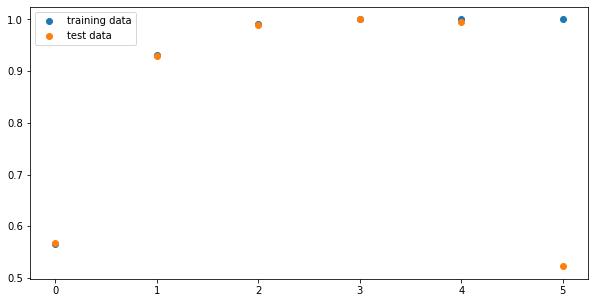

In [121]:
def answer_seven():
    
    import matplotlib.pyplot as plt
    %matplotlib inline

    (mean_train_score, mean_test_score) = answer_six()
    range_value = np.logspace(-4,1,6)

    plt.figure(figsize=(10,5))
    plt.plot(range(0,6,1), mean_train_score, 'o', label='training data')
    plt.plot(range(0,6,1), mean_test_score, 'o', label='test data')
    plt.legend()
    
    return (range_value[0], range_value[5], range_value[3])
answer_seven()

##  Big help from

* https://github.com/tianhuaiyuan/Applied-machine-learning-in-python/blob/master/week2_Assignment.ipynb
* https://github.com/cagdasyigit/coursera-applied-machine-learning-with-python/blob/master/Assignment%2B2.py
